<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_9_SkimLit/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.



## Confirm access to a GPU

In [1]:
!nvidia-smi

Wed Aug 18 14:30:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

Since we´ll be replicating the paper above (PubMed 200k RCT), let´s download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign 
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
#Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

Now we´ve gpt some text data, it´s time to become one with it.

And one of the best ways to become on with the data is to...

> Visualize, visualize, visualize

So with that in mind, let´s write a function to read in all of the lines on a target text file.

In [6]:
# Create function to read lines of a document
def get_lines(filename):
  """
  Read filename (a text filename) and returns the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let´s read in the training lines
train_lines = get_lines(data_dir+"train.txt") #read the lines with the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

# Let´s think about how we want out data to look... 

How I think our data would be best represented...

```
[{'line_number': 0, 
  'target': 'BACKGROUND', 
  'text': "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines': 11}
  ...]
```

In [9]:
def  preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of bastract line data.

  Takes in filename, reads it contents and sorts through each line, extracting
  thing like the target label, the text of the sentence, how many sentences are in the current
  abstract and what sentence number the target line is
  """

  input_lines = get_lines(filename) #get all lines from filename
  abstract_lines = "" #create an empty abstract
  abstract_samples = [] #create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" #reset the abstract string if the lines is an ID line
    elif line.isspace(): #check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() #split abstract lines in separate lines

      #Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create an empty dict for each line
        target_text_split = abstract_line.split("\t") #split target label from text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number #what number line doeas the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) -1 #how many total lines are there in the target abstract (starts with 0 - therfore minus 1)
        abstract_samples.append(line_data) #add line data to abstract sample list
      
    else: #if the above conditions aren´t fulfilled, the line contain a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
#Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [11]:
#Check the first abstract of our training data
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is the format of a list of dictionaries, how about we turn into a DataFram to further visualize

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

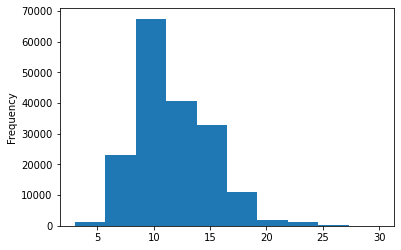

In [14]:
# Check len of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
#First 10 sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [17]:
#One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target columns") and encode them into intergers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_encoded

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we´re going to be trying out a bunch of different models and seeing which one works best.

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
#Evaluate the baseline model
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [22]:
#Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

Download helper function script

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-18 14:30:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-18 14:30:32 (61.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
#Calculate baseline results
baseline_results = calculate_results(val_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data for deep sequence models

Before we start building deeper models, we´ve got to create vectorization and embedding layers

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

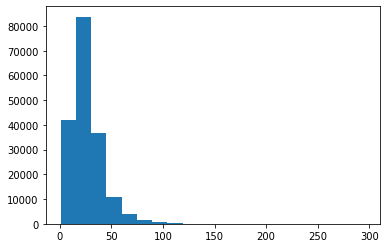

In [28]:
# What´s the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [29]:
# How long of a sentence length cover 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set 
max(sent_lens)

296

### Create text vectorizer layer

Layer which maps our text to numbers

In [31]:
# How many words are in our voca? (taken from tabe 2 in original paper)
max_tokens = 68000

In [32]:
#Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, #number of words in vocab
                                    output_sequence_length=output_seq_len) #desired output length

In [33]:
#Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
in the clinical study , trimethoprim increased metformin area under the plasma concentration-time curve ( auc ) by @ % and decreased metformin and nmn renal clearances by @ and @ % , respectively ( p @ ) .

Length of text: 39

Vectorized text: [[    5     2    47    17 21502    96   886   449   353     2   249  3515
    901   802    22     3   212   886     3 18296   474 23598    22     3
     83    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), #vocab length
                               output_dim=128, #embedding dimension has a huge impact to the amount of model parameters
                               mask_zero=True, #use masking to handle variable sequence length - more efficient
                               name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization :\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 in the clinical study , trimethoprim increased metformin area under the plasma concentration-time curve ( auc ) by @ % and decreased metformin and nmn renal clearances by @ and @ % , respectively ( p @ ) .

Sentence after vectorization :
 [[    5     2    47    17 21502    96   886   449   353     2   249  3515
    901   802    22     3   212   886     3 18296   474 23598    22     3
     83    14     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[ 0.04996998 -0.0050791   0.03492201 ... -0.00837463 -0.03457963
   -0.00834218]
  [ 0.00127194  0.02393489 -0.0436502  ... -0.01008561 -0.01044808
    0.01363288]
  [-0.01915233  0.03753104 -0.00890134 ...  0.02049636 -0.0060767
   -0.0490061 ]
  ...
  [-0.02843924  0.00593068  0.00256225 ... -0.02118996  0.02071042
    0.0285078 ]
  [-0.02843924  0.00593

## Creating datasets

We´re going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [39]:
#Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [40]:
#Take the TensorSliceDataset´s and turn the into prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [41]:
#Create 1D conv model to precess sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [42]:
#compile the model
model_1.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [44]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 36s 14ms/step - loss: 0.9291 - accuracy: 0.6333 - val_loss: 0.6799 - val_accuracy: 0.7447
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6467 - accuracy: 0.7639 - val_loss: 0.6233 - val_accuracy: 0.7776
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6106 - accuracy: 0.7786 - val_loss: 0.5945 - val_accuracy: 0.7899


In [45]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5950 - accuracy: 0.7886


[0.5950395464897156, 0.7885939478874207]

In [46]:
# Make predictions (our model predicts prediction probabilities)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.7375077e-01, 1.1174300e-01, 4.8213325e-02, 3.4310198e-01,
         2.3190891e-02],
        [4.2140228e-01, 2.9433724e-01, 1.7551564e-02, 2.5360849e-01,
         1.3100356e-02],
        [1.7425311e-01, 6.4595416e-03, 1.7358251e-03, 8.1747311e-01,
         7.8447403e-05],
        ...,
        [6.6190992e-06, 4.0964666e-04, 5.5240386e-04, 3.5395810e-06,
         9.9902785e-01],
        [5.6703050e-02, 4.4646996e-01, 1.1344023e-01, 6.8807267e-02,
         3.1457952e-01],
        [1.3907118e-01, 7.4297982e-01, 3.5031728e-02, 4.6512760e-02,
         3.6404513e-02]], dtype=float32), (30212, 5))

In [47]:
#Convert pred probs to classes 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [48]:
# Calculate model_1 results
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.85939361842976,
 'f1': 0.786141773617574,
 'precision': 0.785794562886751,
 'recall': 0.7885939361842976}

## Model 2: Feature extraction with pretrained token embeddings

In [53]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False,
                                       name="universal_sentence_encoder")

In [54]:
#Test out embedding
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
the aim of this study was to assess the influence of tens and ifc on pain relief and to compare the analgesic efficacy of the two currents .
Sentence after embedding:
[ 0.02544235 -0.0657139  -0.02458216 -0.01883439  0.02724715  0.0284366
  0.00247819 -0.01347766 -0.03200301  0.03566462  0.02756824 -0.05045475
  0.06814418  0.0144877  -0.0019835   0.00885457 -0.04310325 -0.00681268
  0.03129879 -0.06489099  0.04034725  0.05396876 -0.05725966 -0.05592928
  0.00585389  0.03730873  0.03058508  0.05662969  0.01771541  0.01670678]

Length of sentence embedding: 512


## Building an fitting an NLP feature extraction model using pretrained embeddings

In [55]:
#Build the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

In [56]:
#Compile the mpdel
model_2.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [58]:
#Fit the model
history_model_2 = model_2.fit(train_dataset, epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset, 
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9180 - accuracy: 0.6514 - val_loss: 0.7967 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7690 - accuracy: 0.7022 - val_loss: 0.7554 - val_accuracy: 0.7045
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7540 - accuracy: 0.7115 - val_loss: 0.7407 - val_accuracy: 0.7094


In [59]:
# Evaluate on the whole validation set
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7435 - accuracy: 0.7128


[0.743467390537262, 0.7128293514251709]

In [60]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2220527e-01, 3.6699620e-01, 2.0178172e-03, 1.9998862e-01,
        8.7920642e-03],
       [3.2512617e-01, 5.1026344e-01, 3.0489613e-03, 1.5873353e-01,
        2.8278101e-03],
       [2.2335680e-01, 1.6562559e-01, 1.4205690e-02, 5.5489653e-01,
        4.1915376e-02],
       ...,
       [2.2162087e-03, 5.6986064e-03, 6.0939159e-02, 9.2319981e-04,
        9.3022281e-01],
       [3.9229263e-03, 4.7054831e-02, 1.8536957e-01, 1.4701240e-03,
        7.6218247e-01],
       [1.7376859e-01, 2.6219210e-01, 4.9912411e-01, 6.2638195e-03,
        5.8651421e-02]], dtype=float32)

In [61]:
#convert prediction probabilities
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [65]:
#Calculate Results
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.28293393353634,
 'f1': 0.7098006418997714,
 'precision': 0.7133717985611195,
 'recall': 0.7128293393353634}

## Model 3: Conv1D with character embeddings

Each character get´s turned into a feature vector

### Creating a character-level tokenizer

In [67]:
# Make funktion to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting nono-chracter-level sequence into character
split_chars(random_train_sentence)

't h e   a i m   o f   t h i s   s t u d y   w a s   t o   a s s e s s   t h e   i n f l u e n c e   o f   t e n s   a n d   i f c   o n   p a i n   r e l i e f   a n d   t o   c o m p a r e   t h e   a n a l g e s i c   e f f i c a c y   o f   t h e   t w o   c u r r e n t s   .'

In [68]:
#Split data into characters
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [69]:
# What´s the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

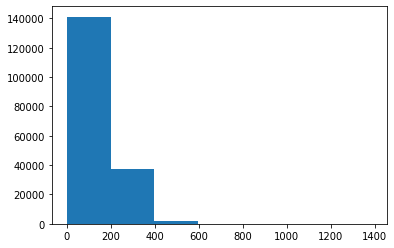

In [70]:
# Check the distribution of our sequences of character level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [74]:
# Find what character length covers 96% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [76]:
# Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [89]:
# create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation", 
                                    name="char_vectorizer")

In [90]:
#Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [91]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common character: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [93]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n {random_train_chars}")
print(f"Length of random_train_char: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
 s t a n d a r d i z e d   s e i z u r e   f r e q u e n c y   (   s s f   )   d u r i n g   t h e   m a i n t e n a n c e   p e r i o d   (   p r i m a r y   e n d   p o i n t   )   w a s   r e d u c e d   w i t h   e s l   @ , @   m g   (   p   =   @   )   ,   a n d   t h e r e   w a s   a   t r e n d   t o w a r d   i m p r o v e m e n t   w i t h   e s l   @   m g   (   p   =   @   )   ,   c o m p a r e d   w i t h   p l a c e b o   .
Length of random_train_char: 174
\Vectorized chars:
 [[ 9  3  5  6 10  5  8 10  4 25  2 10  9  2  4 25 16  8  2 17  8  2 26 16
   2  6 11 19  9  9 17 10 16  8  4  6 18  3 13  2 15  5  4  6  3  2  6  5
   6 11  2 14  2  8  4  7 10 14  8  4 15  5  8 19  2  6 10 14  7  4  6  3
  20  5  9  8  2 10 16 11  2 10 20  4  3 13  2  9 12 15 18 14  5  6 10  3
  13  2  8  2 20  5  9  5  3  8  2  6 10  3  7 20  5  8 10  4 15 14  8  7
  21  2 15  2  6  3 20  4  3 13  2  9 12 15 18 14 11  7 15 14  5  8  2 10
  20  4  3 13 14 12  5 11  2 22  7  0  0  0

### Creating a character level embedding

In [94]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,#get this outout dim from research paper
                              mask_zero=True,
                              name="char_embed")

In [97]:
#Test out character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 s t a n d a r d i z e d   s e i z u r e   f r e q u e n c y   (   s s f   )   d u r i n g   t h e   m a i n t e n a n c e   p e r i o d   (   p r i m a r y   e n d   p o i n t   )   w a s   r e d u c e d   w i t h   e s l   @ , @   m g   (   p   =   @   )   ,   a n d   t h e r e   w a s   a   t r e n d   t o w a r d   i m p r o v e m e n t   w i t h   e s l   @   m g   (   p   =   @   )   ,   c o m p a r e d   w i t h   p l a c e b o   .
Embedded chars (after vectorization):
 [[[ 0.01405365  0.03048572  0.03624963 ...  0.0153697   0.02602369
    0.02988249]
  [-0.02947316  0.02771583  0.04439553 ... -0.04729843  0.04057233
   -0.01868837]
  [ 0.0060816  -0.02823449  0.0231731  ... -0.01296476  0.02165398
    0.03159188]
  ...
  [ 0.00051884 -0.00336124 -0.04982169 ...  0.01945538  0.01016479
    0.02222493]
  [ 0.00051884 -0.00336124 -0.04982169 ...  0.01945538  0.01016479
    0.02222493]
  [ 0.00051884 -0.00336124 -0.04982169 ...  0.01945538  0.01016479
    0.02222493

## Building a Conv1D model to fit on character embeddings

In [106]:
#Build the model
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

In [107]:
#Compile the model
model_3.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [108]:
#create cgar level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [109]:
#Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=valid_char_dataset,
                            validation_steps=int(0.1*len(valid_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 10ms/step - loss: 1.2448 - accuracy: 0.4844 - val_loss: 1.1120 - val_accuracy: 0.5392
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0875 - accuracy: 0.5548 - val_loss: 1.0283 - val_accuracy: 0.5841
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0168 - accuracy: 0.5974 - val_loss: 0.9628 - val_accuracy: 0.6187


In [110]:
#Make predictions with character model only
model_3_preds_probs = model_3.predict(valid_char_dataset)
model_3_preds_probs

array([[0.12363524, 0.37308264, 0.16925305, 0.25965938, 0.07436968],
       [0.1649099 , 0.49357024, 0.07181476, 0.14349811, 0.12620693],
       [0.10626483, 0.24776463, 0.23079275, 0.24225068, 0.17292704],
       ...,
       [0.01682655, 0.06749381, 0.098425  , 0.02744576, 0.7898089 ],
       [0.02458015, 0.12608573, 0.4900758 , 0.03688705, 0.3223713 ],
       [0.28991163, 0.5490681 , 0.04532721, 0.10630754, 0.0093855 ]],
      dtype=float32)

In [111]:
#Convert prediction probs to class labels
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 1])>

In [114]:
#Calculate the results
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_preds)

model_3_results

{'accuracy': 60.98239110287304,
 'f1': 0.6014943786700426,
 'precision': 0.6221821903022114,
 'recall': 0.6098239110287303}